In [ ]:
!pip install qutip

In [ ]:
!pip install krotov

In [ ]:
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
from qutip.control import *


from scipy.stats import unitary_group

In [ ]:
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1.j], [1.j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

Isigma_z = np.array([[1, 0, 0, 0],
           [0, -1, 0, 0],
           [0, 0, 1, 0],
           [0, 0, 0, -1]])

sigma_zI =np.array( [[1, 0, 0, 0],
           [0, 1, 0, 0],
           [0, 0, -1, 0],
           [0, 0, 0, -1]])

Isigma_x = np.array([[0, 1, 0, 0],
           [1, 0, 0, 0],
           [0, 0, 0, 1],
           [0, 0, 1, 0]])

sigma_xI = np.array([[0, 0, 1, 0],
           [0, 0, 0, 1],
           [1, 0, 0, 0],
           [0, 1, 0, 0]])
Isigma_y = np.array([[0, -1.j, 0, 0],
           [1.j, 0, 0, 0],
           [0, 0, 0, -1.j],
           [0, 0, 1.j, 0]])

sigma_yI = np.array([[0, 0, -1.j, 0],
           [0, 0, 0, -1.j],
           [1.j, 0, 0, 0],
           [0, 1.j, 0, 0]])

sigma_x_x = np.array([[0, 0, 0, 1],
           [0, 0, 1, 0],
           [0, 1, 0, 0],
           [1, 0, 0, 0]])

sigma_y_y = np.array([[0, 0, 0, -1],
           [0, 0, 1, 0],
           [0, 1, 0, 0],
           [-1, 0, 0, 0]])

sigma_z_z = np.array([[1, 0, 0, 0],
           [0, -1, 0, 0],
           [0, 0, -1, 0],
           [0, 0, 0, 1]])


In [ ]:
def hamiltonian(omega=1 , ampl0=0.2 ):
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t , args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )
    return [H0,[H1,guess_control]]

In [ ]:
H = hamiltonian()
tlist = np.linspace(0, 5, 500)

In [ ]:
def logical_basis(H):
    H0 = H[0]
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi0, psi1

psi0, psi1 = logical_basis(H)

Energy of qubit transition is 1.000


In [ ]:
proj0 = qutip.ket2dm(psi0)
proj1 = qutip.ket2dm(psi1)

In [ ]:
RandU=[0]*100
for i in range(100):
    RandU[i] = unitary_group.rvs(2)
print(RandU)

[array([[-0.05327608-0.8251048j ,  0.38318906+0.41174006j],
       [-0.18046165+0.53272631j,  0.29002933+0.77428629j]]), array([[ 0.58054866-0.08531917j, -0.7593629 +0.28116167j],
       [-0.1749783 +0.79061147j, -0.00535089+0.58676015j]]), array([[-0.23031458-0.52104137j,  0.36312551-0.73729977j],
       [-0.40188709-0.71690854j, -0.2022308 +0.53257077j]]), array([[ 0.46441852-0.72831267j, -0.22939859-0.44861162j],
       [-0.42944101-0.26354603j,  0.76218085-0.40645326j]]), array([[-0.3947472 -0.35584929j,  0.82179942+0.20540605j],
       [ 0.4370215 -0.72564326j,  0.02835705-0.53070702j]]), array([[-0.12531548-0.48152277j, -0.57786221+0.64692127j],
       [-0.74142533-0.45024475j, -0.0205809 -0.49713637j]]), array([[ 0.98068574+0.18055234j, -0.0113876 -0.07434151j],
       [-0.00842546-0.0747352j ,  0.89948217-0.43043638j]]), array([[ 0.09341595-0.60328523j, -0.7456794 -0.26698805j],
       [-0.61827884+0.49502693j, -0.28457564-0.54008918j]]), array([[-0.04402086-0.11477346j, -0.046

In [ ]:
objectives=[0]*100
for i in range(100):
  objectives[i] = krotov.gate_objectives(
      basis_states=[psi0, psi1], gate=RandU[i], H=H
  )



def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
   )

pulse_options = {H[1][1]: dict(lambda_a=1, update_shape=S)}

In [ ]:
results1=[]
for i in range(100):

  opt_result = krotov.optimize_pulses(
      objectives[i],
      pulse_options=pulse_options,
      tlist=tlist,
      propagator=krotov.propagators.expm,
      chi_constructor=krotov.functionals.chis_sm,
      info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_sm),
      check_convergence=krotov.convergence.Or(
          krotov.convergence.value_below('1e-3', name='J_T'),
          krotov.convergence.check_monotonic_error,
      ),
      store_all_pulses=True,
  )

  results.append(opt_result)


  #j_f=[]
  #j_f.append(opt_result.info_vals)
#print(j_f)


iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     7.03e-01    0.00e+00   7.03e-01        n/a        n/a     3
1     4.89e-01    8.90e-02   5.78e-01  -2.15e-01  -1.26e-01     7
2     3.22e-01    7.41e-02   3.96e-01  -1.66e-01  -9.24e-02     6
3     1.78e-01    6.63e-02   2.44e-01  -1.44e-01  -7.80e-02     6
4     8.03e-02    4.58e-02   1.26e-01  -9.75e-02  -5.17e-02     7
5     3.17e-02    2.32e-02   5.49e-02  -4.85e-02  -2.54e-02     6
6     1.19e-02    9.56e-03   2.15e-02  -1.98e-02  -1.03e-02     7
7     4.43e-03    3.63e-03   8.06e-03  -7.47e-03  -3.85e-03     6
8     1.66e-03    1.35e-03   3.01e-03  -2.77e-03  -1.42e-03     8
9     6.26e-04    5.04e-04   1.13e-03  -1.03e-03  -5.30e-04     6
iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     5.44e-01    0.00e+00   5.44e-01        n/a        n/a     3
1     2.28e-01    1.34e-01   3.62e-01  -3.16e-01  -1.81e-01     6
2     8.85e-02    6.27e-02   1.51e-01  -1.39e-01  -7.66e-02     7
3     2.37

In [ ]:
results

In [ ]:
J_F_const_1K=[]
for i in range(100):
  J_F_const_1K.append(results[i].info_vals)

J_F_const_1K

[[0.7033531132802264,
  0.48858477352688656,
  0.32210767565749954,
  0.17781224268713847,
  0.08027532446974706,
  0.031729547050092455,
  0.01190562068275125,
  0.004431645021418351,
  0.0016592412827955982,
  0.0006258739748344899],
 [0.5435736672222743,
  0.2278046257485129,
  0.08852490056583195,
  0.023678300447642076,
  0.004679240601986656,
  0.0008040234841486527],
 [0.9806309687018553,
  0.8589350337693887,
  0.39120234586962754,
  0.046584780262212466,
  0.00340415123155291,
  0.00044724654661887353],
 [0.4766741374220086,
  0.234044556459574,
  0.19312351449353526,
  0.14537969504319503,
  0.06942080011663643,
  0.016283942830141118,
  0.0025116312464718016,
  0.0003689906491445294],
 [0.5532812215357861,
  0.1345691522264999,
  0.04328537473427274,
  0.011196456392134402,
  0.0021258614834842593,
  0.0003432886329863827],
 [0.7033531132802264,
  0.48858477352688656,
  0.32210767565749954,
  0.17781224268713847,
  0.08027532446974706,
  0.031729547050092455,
  0.01190562068

In [ ]:
iter_sec_const_1K=[]
for i in range(100):
  iter_sec_const_1K.append(results[i].iter_seconds)

iter_sec_const_1K

[[3, 7, 6, 6, 6, 7, 6, 6, 7, 6],
 [3, 6, 7, 6, 6, 6],
 [3, 7, 6, 6, 7, 6],
 [2, 6, 6, 6, 7, 6, 7, 6],
 [3, 7, 6, 6, 6, 6],
 [3, 7, 6, 6, 7, 6, 7, 6, 8, 6],
 [3, 6, 7, 6, 7, 6],
 [3, 6, 7, 6, 7, 6],
 [3, 6, 7, 6, 7, 6, 7, 6],
 [3, 6, 7, 6, 7, 7],
 [2, 6, 7, 8, 6, 7, 6, 7, 6, 7, 6, 7, 7, 6],
 [3, 7, 6, 6],
 [2, 7, 6, 6, 6, 6, 7],
 [3, 6, 6, 6, 6, 6, 6, 7, 6],
 [3, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 7, 6, 7, 6, 6, 6],
 [4, 6, 6, 6],
 [4, 6, 6, 6, 7, 6, 7, 6, 6, 7],
 [3, 6, 7, 6],
 [3, 6, 7, 6, 7, 6, 6, 7, 6, 7],
 [2, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6],
 [3, 7, 7, 6],
 [3, 6, 6, 6, 7],
 [3, 7, 6, 7, 6, 7, 6, 6, 7, 6, 7, 6],
 [3, 6, 7, 6, 6, 6, 7],
 [2, 7, 6, 8, 6],
 [2, 7, 6, 6, 6, 6, 7],
 [2, 6, 6, 7],
 [3, 6, 6, 6, 6],
 [3, 7, 6, 7, 6],
 [3, 6, 7, 6, 7, 6, 6, 7],
 [3, 6, 6, 7, 6, 7, 6, 6, 6, 7, 6, 7, 7, 6],
 [3, 7, 6, 6, 7, 6],
 [3, 7, 6, 6, 7, 6, 7],
 [3, 6, 7, 7, 6, 7],
 [3, 7, 6, 7, 6, 7, 6, 7, 6, 6],
 [2, 7, 6, 7, 6, 6, 6, 6, 7],
 [2, 6, 6, 7, 6, 7, 6, 8, 6],
 [3, 6, 7, 6, 6],
 [3, 7, 6, 7, 6,

In [ ]:
t_conv_const_1K=[]

for i in range(100):
  t_sec = 0
  t_conv_i=[]
  for j in range (len(iter_sec_const_1K[i])):
     t_sec = iter_sec_const_1K[i][j] + t_sec
     t_conv_i.append(t_sec)
  t_conv_const_1K.append(t_conv_i)

In [ ]:
N=100
t_it_avg_const_1K=0
t1=0
for i in range(N):
  t1= t_conv_const_1K[i][-1]/len(iter_sec_const_1K[i]) + t1

t_it_avg_const_1K = t1/N



t_it_avg_const_1K

5.866265256501325

In [ ]:
N=100
t_conv_avg_const_1K=0
sum=0
for i in range(N):

  sum=t_conv_const_1K[i][-1] + sum
t_conv_avg_const_1K= sum/N

t_conv_avg_const_1K

49.57

In [ ]:
N=100
J_F_avg_const_1K=0
sum=0
for i in range(N):

  sum=J_F_const_1K[i][-1] + sum
J_F_avg_const_1K= sum/N

J_F_avg_const_1K

0.0005808954382848474

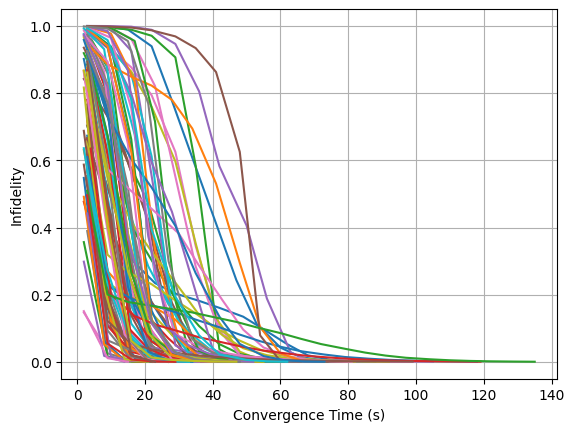

In [ ]:
for i in range(100):
  plt.plot(t_conv_const_1K[i], J_F_const_1K[i])
  #plot_conv(J_F_100_1K[i], t_conv_100_1K[i])
  plt.grid('on')
  plt.xlabel("Convergence Time (s)")
  plt.ylabel("Infidelity")
  #plt.title('Krotov')
  #plt.legend()
  plt.label=('Krotov')
#plt.savefig('ConvPlots5.png')